#  Autoencoding Fashion MNIST Data

## 1.0 Study purpose

* Build and train an autoencoder for the Fashion MNIST dataset.
* Compress the images into a lower-dimensional representation.
* Reconstruct the original images from the compressed representations.
* Monitor the reconstruction loss during training.
* Evaluate performance by visualizing reconstructed images.

## 2.0 Data Understanding

### 2.1 Prelimary data analysis

#### 2.1.1 Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
import tensorflow as tf

%matplotlib inline

In [2]:
from matplotlib import pyplot
from keras.datasets import mnist, fashion_mnist, cifar100
from keras.models import Model
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Dense , Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.constraints import max_norm
from keras.optimizers import Adam ,RMSprop
from keras import backend as K
from subprocess import check_output
from sklearn.preprocessing import label_binarize
from sklearn.metrics import label_ranking_average_precision_score

#### 2.1.2 Suppress warnings

In [3]:
warnings.filterwarnings('ignore')

#### 2.1.3 Data ingestion

In [4]:
(train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


#### 2.1.4 Set random seed

In [6]:
np.random.seed(42)

### 2.2 Data quality

#### 2.2.1 Training data sample images

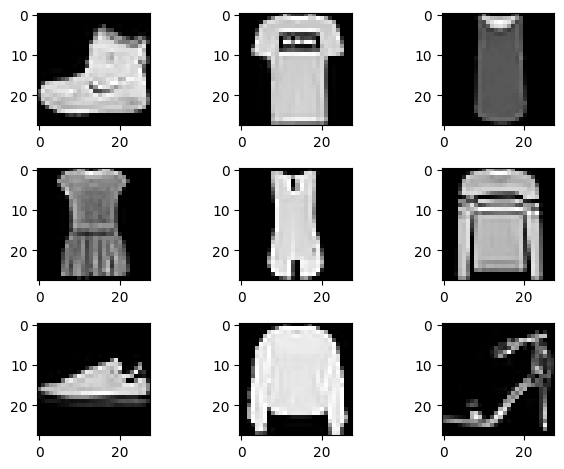

In [7]:
for i in range(9):
    pyplot.subplot(3, 3, i + 1)
    pyplot.imshow(train_X[i], cmap=pyplot.get_cmap('gray'))

pyplot.tight_layout()
pyplot.show()

#### 2.2.2 Training label data counts

In [8]:
unique, counts = np.unique(train_y, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))

Train labels:  {np.uint8(0): np.int64(6000), np.uint8(1): np.int64(6000), np.uint8(2): np.int64(6000), np.uint8(3): np.int64(6000), np.uint8(4): np.int64(6000), np.uint8(5): np.int64(6000), np.uint8(6): np.int64(6000), np.uint8(7): np.int64(6000), np.uint8(8): np.int64(6000), np.uint8(9): np.int64(6000)}


#### 2.2.3 Testing label data counts

In [9]:
unique, counts = np.unique(test_y, return_counts=True)
print("\nTest labels: ", dict(zip(unique, counts)))


Test labels:  {np.uint8(0): np.int64(1000), np.uint8(1): np.int64(1000), np.uint8(2): np.int64(1000), np.uint8(3): np.int64(1000), np.uint8(4): np.int64(1000), np.uint8(5): np.int64(1000), np.uint8(6): np.int64(1000), np.uint8(7): np.int64(1000), np.uint8(8): np.int64(1000), np.uint8(9): np.int64(1000)}


#### 2.2.4 Label descriptions

1.	T-shirt/top
2.	Trouser
3.	Pullover
4.	Dress
5.	Coat
6.	Sandal
7.	Shirt
8.	Sneaker
9.	Bag
10.	Ankle boot

### 2.3 Exploratory data analysis

## 3.0 Data preprocessing

### 3.1 Compute the number of labels

In [10]:
num_labels = len(np.unique(train_y))
num_labels

10

### 3.2 Encode output data

In [11]:
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

### 3.3 Image dimensions

In [12]:
image_size = train_X.shape[1]
input_size = image_size * image_size
input_size

784

In [13]:
train_X = np.expand_dims(train_X, axis=-1)

### 3.4 Number of classes

In [14]:
num_classes = test_y.shape[1]

#### 3.5.1 Training data

In [15]:
train_X1 = np.reshape(train_X, [-1, input_size])
train_X1 = train_X1.astype('float32') / 255
train_X = train_X.astype('float32') / 255

In [16]:
print('X1_train: ' + str(train_X1.shape))
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))

X1_train: (60000, 784)
X_train: (60000, 28, 28, 1)
Y_train: (60000, 10)


#### 3.5.2 Testing data

In [17]:
test_X1 = np.reshape(test_X, [-1, input_size])
test_X1 = test_X1.astype('float32') / 255
test_X = test_X.astype('float32') / 255

In [18]:
print('X1_test:  '  + str(test_X1.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X1_test:  (10000, 784)
X_test:  (10000, 28, 28)
Y_test:  (10000, 10)


### 4.0 Modeling

### 4.1 Model input

In [19]:
input_img = Input(shape=(784,))

### 4.2 Encoder layers

In [20]:
e1 = Dense(256, activation='relu')(input_img)

In [21]:
e2 = Dense(128, activation='relu')(e1)

In [22]:
e3 = Dense(64, activation='relu')(e2)

In [23]:
encoded = Dense(32, activation='relu')(e3)

### 4.3 Decoder layers

In [24]:
d1 = Dense(64, activation='sigmoid')(encoded)

In [25]:
d2 = Dense(128, activation='sigmoid')(d1)

In [26]:
d3 = Dense(256, activation='sigmoid')(d2)

In [27]:
decoded = Dense(784, activation='sigmoid')(d3)

### 4.4 Autoencoder model

In [28]:
autoencoder = Model(input_img, decoded)

In [29]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 489,136 (1.87 MB)

 Trainable params: 489,136 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

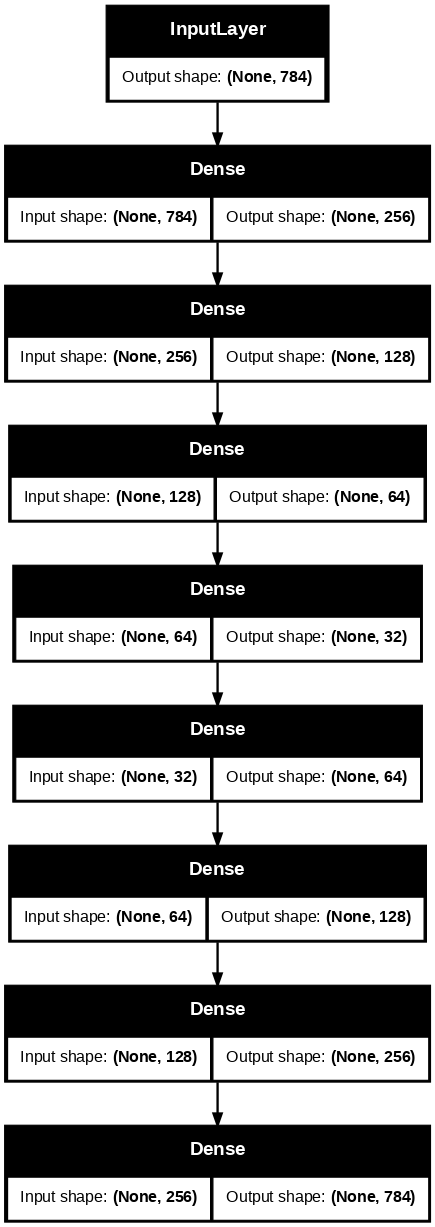

In [30]:
plot_model(autoencoder, to_file='mlp-fashion-mnist-encode.png', show_shapes=True, dpi=84)

### 4.5 Encoder model

In [31]:
encoder = Model(input_img, encoded)

### 4.6 Decoder model

In [32]:
latent_input = Input(shape=(32,), name="decoder_input")

In [33]:
x = Dense(64, activation='sigmoid')(latent_input)

In [34]:
x = Dense(128, activation='sigmoid')(x)

In [35]:
x = Dense(256, activation='sigmoid')(x)

In [36]:
decoded_output = Dense(784, activation='sigmoid')(x)

In [37]:
decoder = Model(latent_input, decoded_output)

### 4.6 Compile the autoencoder

In [38]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### 4.7 Fit the autoencoder

In [39]:
autoencoder.fit(train_X1, train_X1,
                epochs=15,
                batch_size=128,
                shuffle=True,
                validation_data=(test_X1, test_X1),
                verbose=1)

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.0045 - loss: 0.4662 - val_accuracy: 0.0167 - val_loss: 0.3598
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.0152 - loss: 0.3532 - val_accuracy: 0.0095 - val_loss: 0.3436
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.0108 - loss: 0.3385 - val_accuracy: 0.0091 - val_loss: 0.3286
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.0113 - loss: 0.3245 - val_accuracy: 0.0116 - val_loss: 0.3179
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.0134 - loss: 0.3143 - val_accuracy: 0.0113 - val_loss: 0.3127
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.0143 - loss: 0.3099 - val_accuracy: 0.0145 - val_loss: 0.3100
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.0160 - loss: 0.3067 - val_accuracy: 0.0135 - val_loss: 0.3065
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.0167 - loss: 0.3035 - val_a

## 5.0 Evaluation

### 5.1 Plot image transformation

In [40]:
encoded_images = encoder.predict(test_X1)
predicted = autoencoder.predict(test_X1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


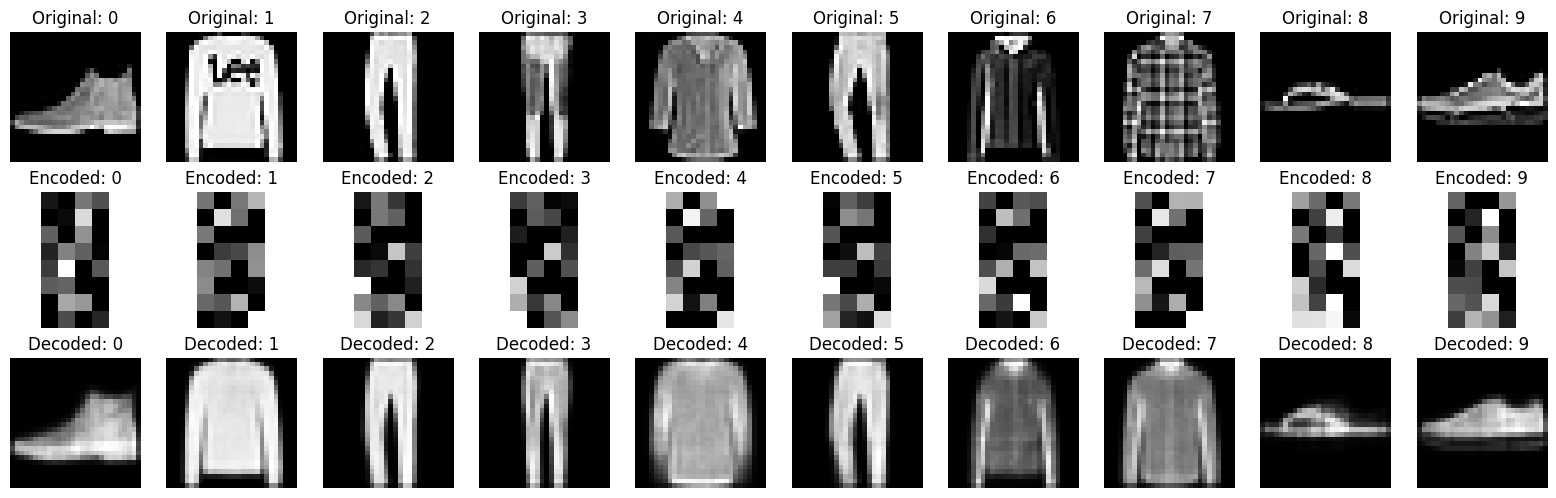

In [41]:
plt.figure(figsize=(40, 6))
for i in range(10):
  ax = plt.subplot(3, 20, i + 1)
  plt.imshow(test_X1[i].reshape(28, 28), cmap='gray')
  plt.title("Original: {}".format(i))
  plt.axis('off')

  ax = plt.subplot(3, 20, i + 1 + 20)
  plt.imshow(encoded_images[i].reshape(8, 4), cmap='gray')
  plt.title("Encoded: {}".format(i))
  plt.axis('off')

  ax = plt.subplot(3, 20, 2 * 20 + i + 1)
  plt.imshow(predicted[i].reshape(28, 28), cmap='gray')
  plt.title("Decoded: {}".format(i))
  plt.axis('off')
plt.show()

### 5.2 Plot latent space

In [42]:
mu = encoder.predict(test_X1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [43]:
labels = np.argmax(test_y, axis=1) if test_y.ndim == 2 else test_y

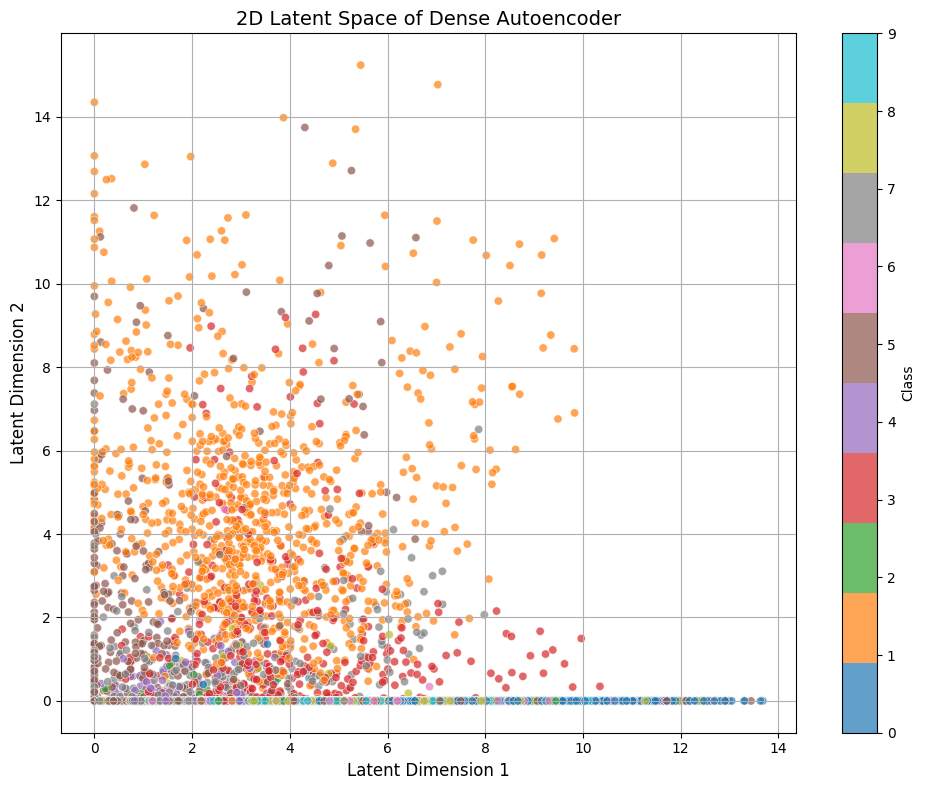

In [44]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(mu[:, 0], mu[:, 1], c=labels, cmap='tab10', alpha=0.7, edgecolors='w', linewidths=0.5)
plt.xlabel("Latent Dimension 1", fontsize=12)
plt.ylabel("Latent Dimension 2", fontsize=12)
plt.title("2D Latent Space of Dense Autoencoder", fontsize=14)
plt.colorbar(scatter, ticks=range(10), label='Class')
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
sample_vector = np.array([[6, 11]+ [0]*30])

In [46]:
decoded_example = decoder.predict(sample_vector)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


In [47]:
decoded_image = decoded_example.reshape(28, 28)

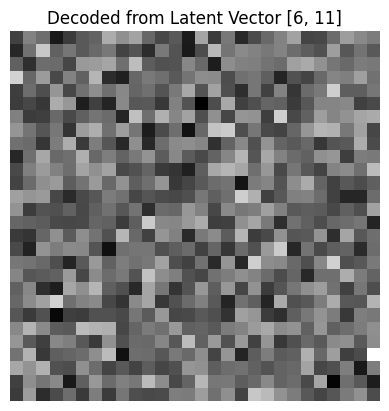

In [48]:
plt.imshow(decoded_image, cmap='gray')
plt.title("Decoded from Latent Vector [6, 11]")
plt.axis('off')
plt.show()

### 5.3 Calculate label ranking average precision (LRAP) score

In [55]:
classifier_output = Dense(10, activation='softmax')(encoded)

In [56]:
classifier = Model(inputs=input_img, outputs=classifier_output)

In [57]:
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
classifier.fit(train_X1, train_y, epochs=15, batch_size=128, validation_data=(test_X1, test_y))

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6527 - loss: 1.1993 - val_accuracy: 0.8455 - val_loss: 0.4324
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8628 - loss: 0.3780 - val_accuracy: 0.8513 - val_loss: 0.4026
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8799 - loss: 0.3246 - val_accuracy: 0.8682 - val_loss: 0.3578
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8909 - loss: 0.2967 - val_accuracy: 0.8656 - val_loss: 0.3668
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8917 - loss: 0.2876 - val_accuracy: 0.8708 - val_loss: 0.3541
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9013 - loss: 0.2635 - val_accuracy: 0.8790 - val_loss: 0.3341
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9032 - loss: 0.2555 - val_accuracy: 0.8836 - val_loss: 0.3326
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9093 - loss: 0.2357 - val_accuracy: 

In [61]:
true_y = label_binarize(np.argmax(test_y, axis=1), classes=range(10))

In [69]:
score_y = classifier.predict(test_X1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [70]:
lrap = label_ranking_average_precision_score(true_y, score_y)
print(f"LRAP Score: {lrap:.4f}")

LRAP Score: 0.9382


In [67]:
true_y.shape

(10000, 10)

In [68]:
score_y.shape

(10000, 784)

## 6.0 Deployment

Paper: ComfortJDDS8150-2 - Autoencoding Fashion MNIST Data